In [1]:
import pandas as pd
import numpy as np
import itertools
import os
import json
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
import matplotlib.lines as lines


sns.set(font_scale=1.4)

In [2]:
path = "./results"

def load_experiment_results(path, experiment_dir, filename):
    
    path = os.path.join(path,experiment_dir)

    directory = os.fsencode(path)
    df_full = None

    for file in os.listdir(directory):
        fn = os.fsdecode(file)
        if fn.find(filename) != -1: 

            df = pd.read_csv(os.path.join(path, fn))

            if len(df) == 1:
                continue

            #print(fn)
            if df_full is None:
                df_full = df
            else:
                df_full=  pd.concat([df_full, df])
        else:
            print("file ignored:", fn)
    
    return df_full

In [3]:

def get_ap_df(model_train_size):
    with open(f"./results/maps_{model_train_size}.txt","r") as file:
        js_obj = json.load(file)

    records = [{"image_id":key, "segm_ap": js_obj[key]["segm"]["AP"] }for key in js_obj.keys()]
    df = pd.DataFrame.from_records(records)
    df["model_train_size"] = model_train_size
    
    return df

def latex_pd(df):
    df = df.round(3)
    return df.to_latex(index=False)

In [4]:

def get_experiment(path, experiment_dir, filename,  agg_cols, filter_cols=None):
    
    
    agg_cols_wio_train = list(set(agg_cols) - set(["model_train_size"]))
    
    tta_gs_df = load_experiment_results(path, experiment_dir, filename)
    
    if filter_cols:
        for col in filter_cols.keys():
            tta_gs_df = tta_gs_df[tta_gs_df[col] == filter_cols[col]]
    
    tta_gs_df = tta_gs_df[tta_gs_df["model_train_size"] != 45]
    #tta_gs_df = tta_gs_df[tta_gs_df["model_train_size"] != 15]
    
    if len(tta_gs_df) == 0:
        print("error in import")
        return
    
    df_ap = None
    for model_train_size in [15, 45, 240, 3000, 5800]:
        df = get_ap_df(model_train_size)
        if df_ap is None:
            df_ap = df
        else:
            df_ap =  pd.concat([df_ap, df])
    
    
    tta_gs_df =  pd.merge(
        tta_gs_df,
        df_ap,
        how="inner",
        on=["model_train_size","image_id"])


    tta_gs_df["certainty"] = 1 - tta_gs_df["agg_uncertainty"]
    tta_gs_df["ap_scale"] = tta_gs_df["segm_ap"]/100

    tta_gs_df["neg_conf_gap"] = (tta_gs_df["ap_scale"] - tta_gs_df["certainty"]) * (tta_gs_df["ap_scale"] - tta_gs_df["certainty"] < 0)


    


    records = []
    
    tta_gs_df["is_quant_i"] = 0

    agg_cols_values = [tta_gs_df[col_name].unique() for col_name in agg_cols]
    for element in itertools.product(*agg_cols_values):
        tmp_df = tta_gs_df.copy()
        for col in agg_cols:
            tmp_df = tmp_df[tmp_df[col] == element[agg_cols.index(col)]]

        record = {col:tmp_df[col].values[0] for col in agg_cols}

        record["corr"] = tmp_df[["certainty", "ap_scale"]].corr()["certainty"]["ap_scale"]
        record["neg_conf_gap"] = tmp_df["neg_conf_gap"].sum()
             
        quant = 0.25
        
        intersection = set(tmp_df[tmp_df["ap_scale"] < tmp_df["ap_scale"].quantile(quant)]["image_id"].values).intersection(set(tmp_df[tmp_df["certainty"] < tmp_df["certainty"].quantile(quant)]["image_id"].values))
        union = len(set(tmp_df[tmp_df["ap_scale"] < tmp_df["ap_scale"].quantile(quant)]["image_id"].values).union(set(tmp_df[tmp_df["certainty"] < tmp_df["certainty"].quantile(quant)]["image_id"].values)))
        record["quant_iou"] = len(intersection)/union
        
        for id_ in list(intersection):
            tta_gs_df.loc[(tta_gs_df["image_id"] == id_) & (tta_gs_df["model_train_size"] == tmp_df["model_train_size"].values[0])  & (tta_gs_df["dropout_prob"] == tmp_df["dropout_prob"].values[0]) & (tta_gs_df["num_mc_samples"] == tmp_df["num_mc_samples"].values[0]), "is_quant_i"] = 1

        
        
        #(tmp_df[tmp_df["certainty"] < tmp_df["certainty"].quantile(.5)]["ap_scale"].mean() - tmp_df["ap_scale"].mean()) / (tmp_df[tmp_df["ap_scale"] < tmp_df["ap_scale"].quantile(.5)]["ap_scale"].mean()- tmp_df["ap_scale"].mean())
        
        #record["u_worst_map"] = (tmp_df[tmp_df["ap_scale"] < tmp_df["ap_scale"].quantile(.5)]["certainty"].mean() - tmp_df["certainty"].mean()) / (tmp_df[tmp_df["certainty"] < tmp_df["certainty"].quantile(.5)]["certainty"].mean()- tmp_df["certainty"].mean())
        


        #print(record)    
        records.append(record)
    
    
    
        

    df = pd.DataFrame.from_records(records)

    print(df.sort_values(by=["corr"], ascending=False), "\n")
    print(df.sort_values(by=["quant_iou"], ascending=False))
    
    
    print(latex_pd(df[df.groupby("model_train_size")['corr'].transform(max) == df['corr']].sort_values("model_train_size")[["model_train_size"] + agg_cols_wio_train + ["corr", "quant_iou"]]), "\n")
    
    print(latex_pd(df.groupby(agg_cols_wio_train).mean().reset_index().sort_values(by=["corr"], ascending=False)[agg_cols_wio_train + ["corr", "quant_iou"]]), "\n")

    for col in agg_cols:
        print(latex_pd(df.groupby(by=[col]).mean().reset_index().sort_values(by=["corr"], ascending=False)[[col, "corr", "quant_iou"]]), "\n")

    for model_train_size in df["model_train_size"].unique():
        tmp_df = df[df["model_train_size"] == model_train_size]
        tmp_df = tmp_df[tmp_df["num_mc_samples"] == 10]
        print(model_train_size)
        print(latex_pd(tmp_df.groupby(agg_cols_wio_train).mean().reset_index().sort_values(by=["corr"], ascending=False)[agg_cols_wio_train + ["corr", "quant_iou"]]), "\n")
    
    agg_cols_values = [tta_gs_df[col_name].unique() for col_name in agg_cols_wio_train if col_name != "model_train_size"]
    print(agg_cols_values)

    for element in itertools.product(*agg_cols_values):
        tmp_df = tta_gs_df.copy()
        
        for col in agg_cols_wio_train:
            tmp_df = tmp_df[tmp_df[col] == element[agg_cols_wio_train.index(col)]]


        tmp_df["Certainty"] = tmp_df["certainty"]
        tmp_df["Normalized mAP"] = tmp_df["ap_scale"]
        tmp_df["Size of training data set"] = tmp_df["model_train_size"]
        
        print({col:tmp_df[col].values[0] for col in agg_cols_wio_train})
        myplot = sns.lmplot(data=tmp_df, x="Certainty", y="Normalized mAP", hue="is_quant_i", ci=None, col='Size of training data set', line_kws={'color': 'orange'}, col_wrap=2, fit_reg=False, scatter=True, legend=False)
        
        
        axes = myplot.fig.axes
        
        x = np.arange(0.25, 1.02, .05)

        for ax in axes:
            ax.plot(x, x, c="gray")
            ax.plot(np.array([0.25, 1]), np.array([1, 1]), c="gray")


            
            

        
        plt.show()
        
        


file ignored: .ipynb_checkpoints
     num_mc_samples  dropout_prob  model_train_size      corr  neg_conf_gap  \
23               20          0.35              3000  0.385737     -2.703316   
67               40          0.45              3000  0.368272     -2.027988   
115              30          0.45              3000  0.363235     -2.143732   
27               10          0.55              3000  0.362362     -1.572221   
71               40          0.35              3000  0.361638     -2.664701   
..              ...           ...               ...       ...           ...   
116              30          0.35                15 -0.258290     -0.657960   
72                5          0.55                15 -0.268983     -0.011930   
40               10          0.45                15 -0.321072     -0.354145   
92                5          0.35                15 -0.322811     -0.231380   
88                5          0.45                15 -0.379694     -0.146333   

     quant_iou  
2

/tmp/ipykernel_861469/976688089.py:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return df.to_latex(index=False)
/tmp/ipykernel_861469/976688089.py:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return df.to_latex(index=False)
/tmp/ipykernel_861469/976688089.py:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is 

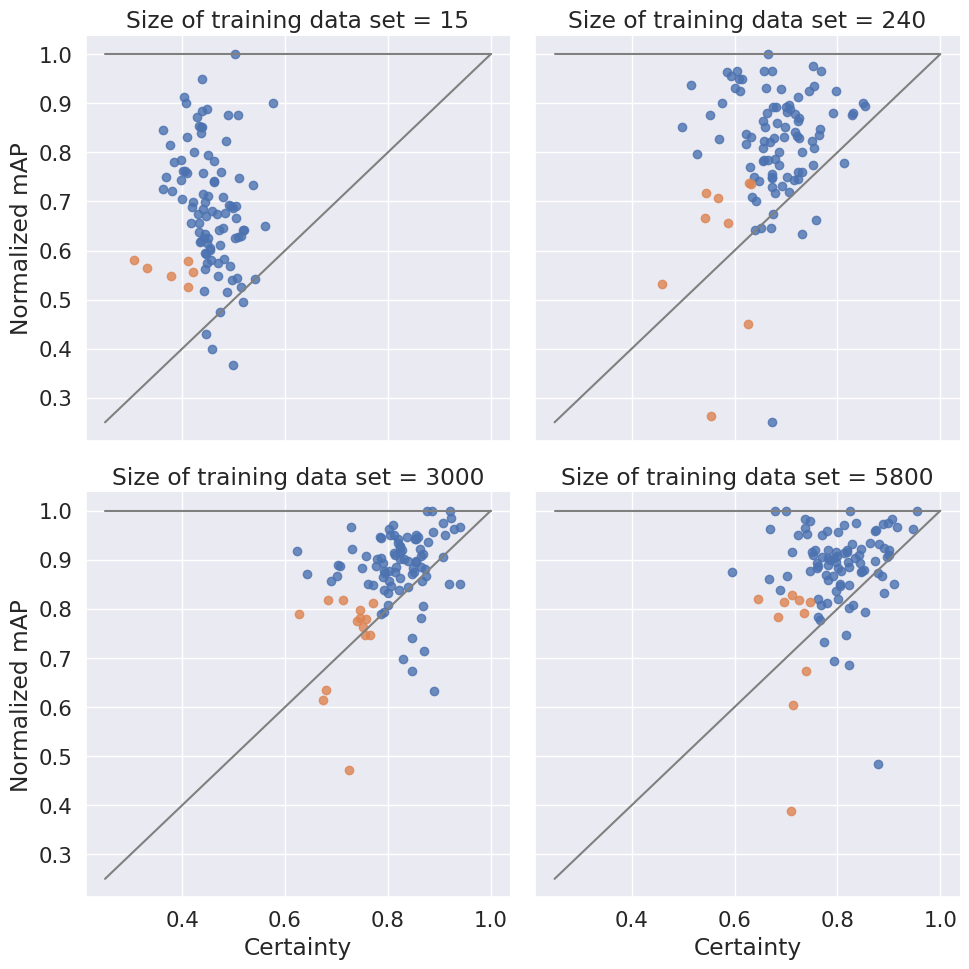

{'dropout_prob': 0.55, 'num_mc_samples': 10}


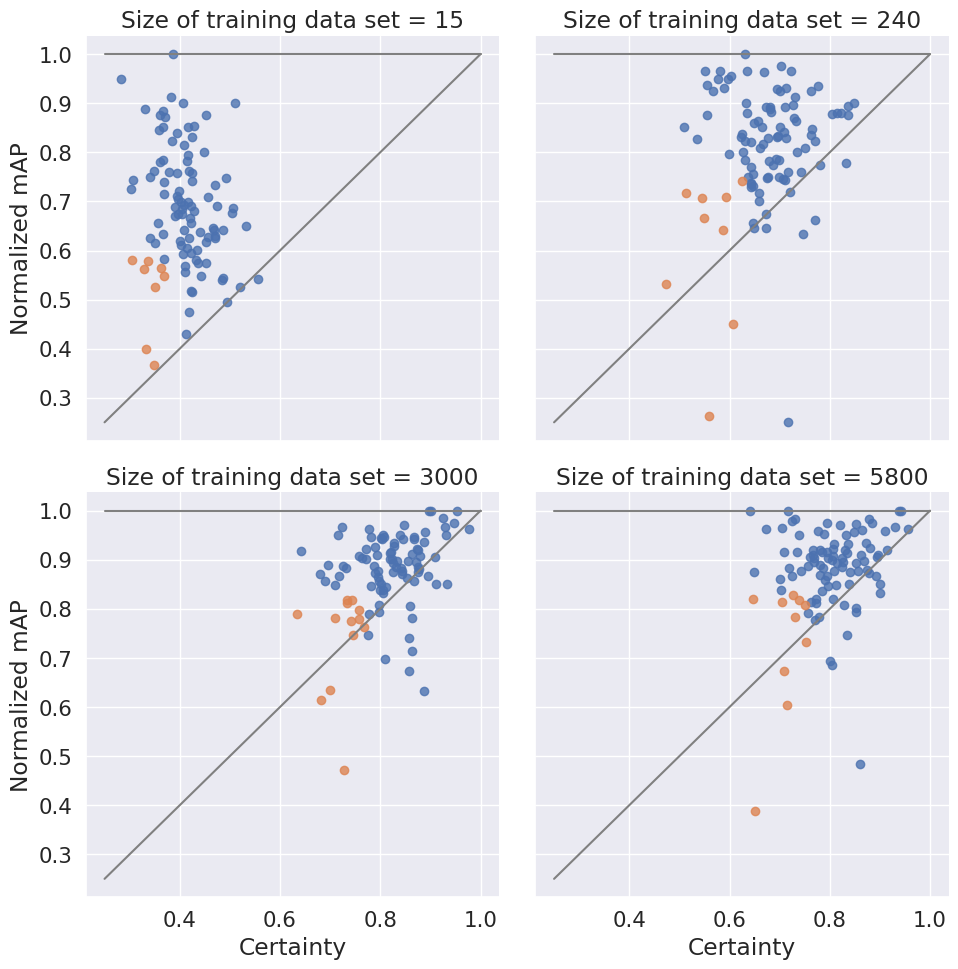

{'dropout_prob': 0.55, 'num_mc_samples': 40}


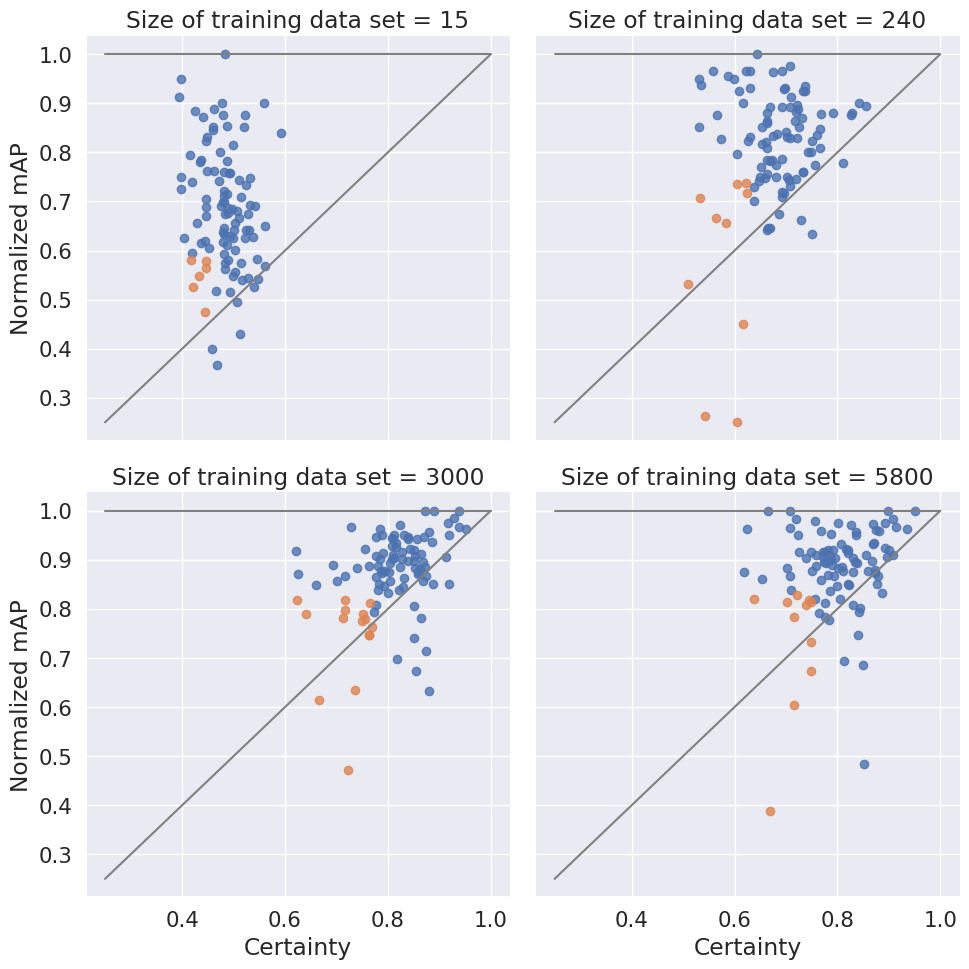

{'dropout_prob': 0.55, 'num_mc_samples': 5}


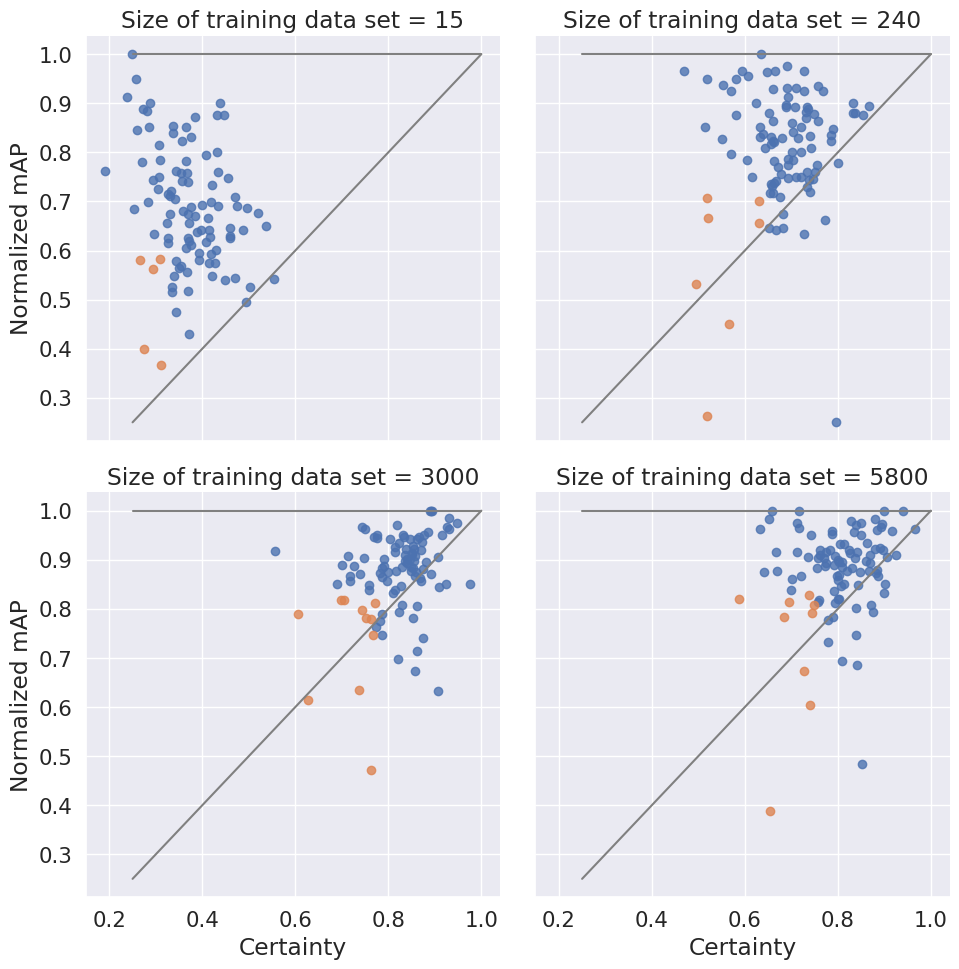

{'dropout_prob': 0.55, 'num_mc_samples': 30}


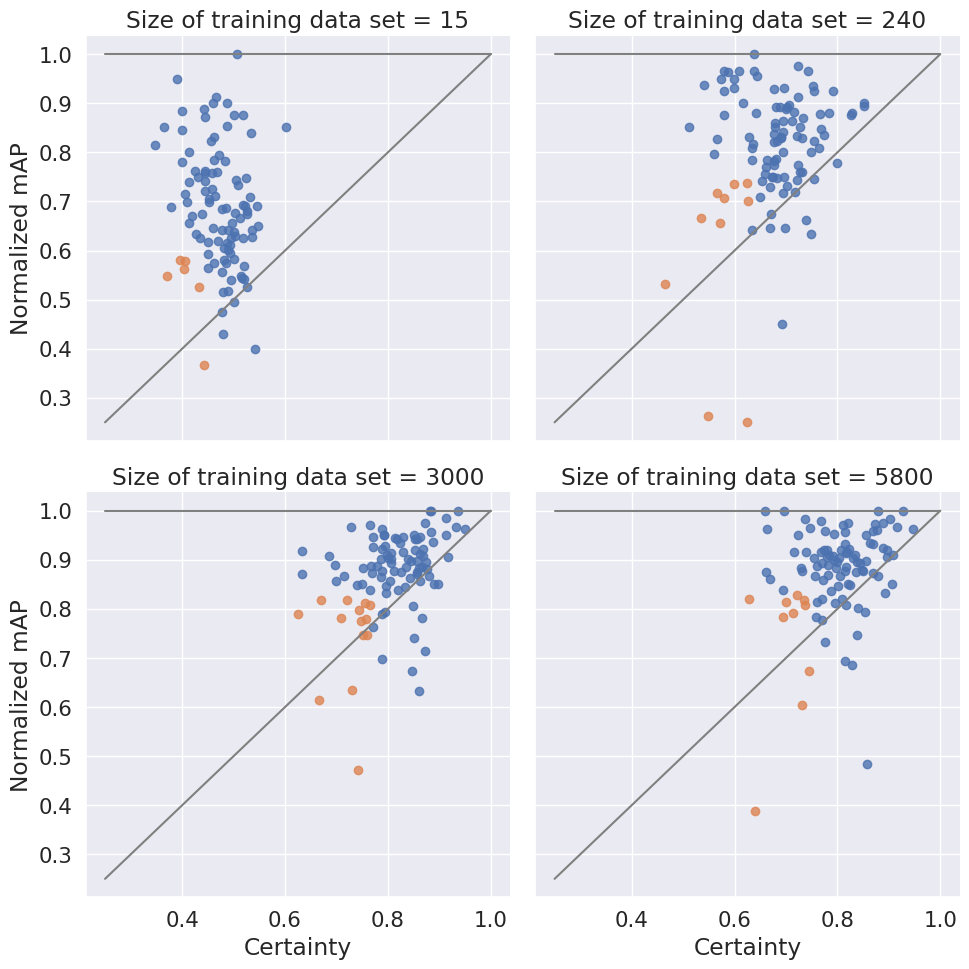

{'dropout_prob': 0.15, 'num_mc_samples': 20}


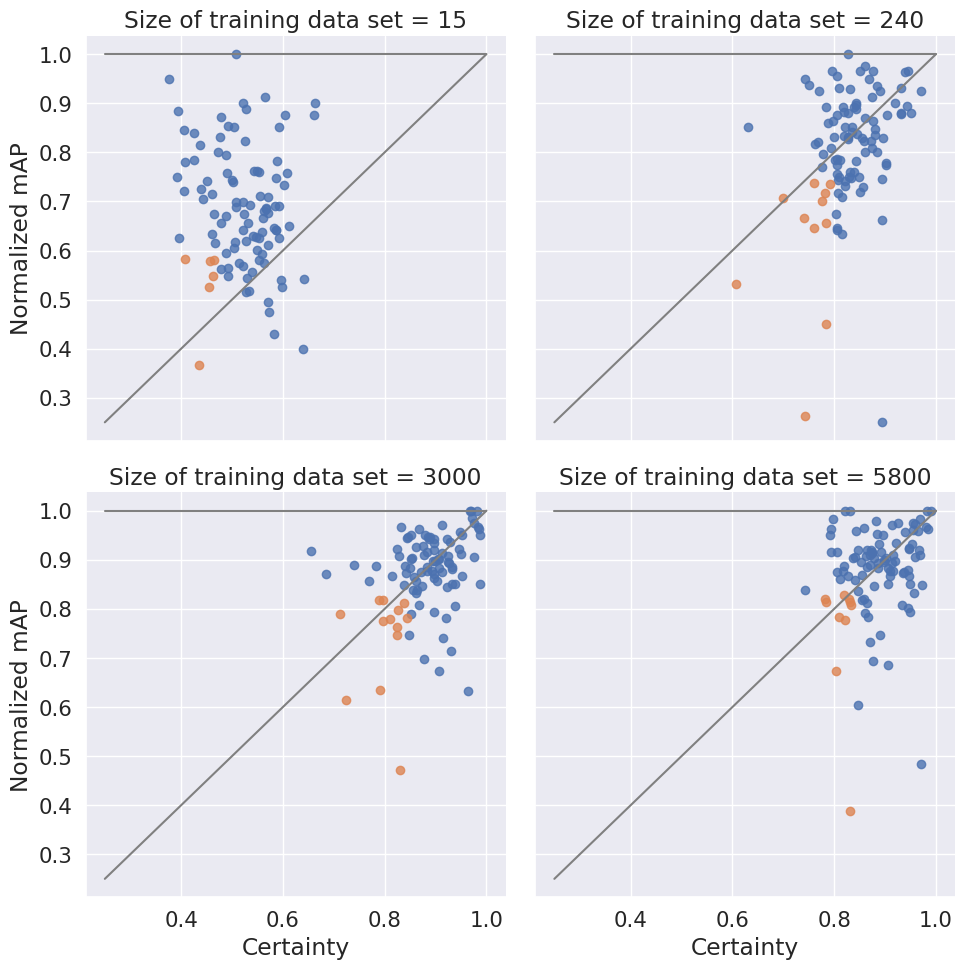

{'dropout_prob': 0.15, 'num_mc_samples': 10}


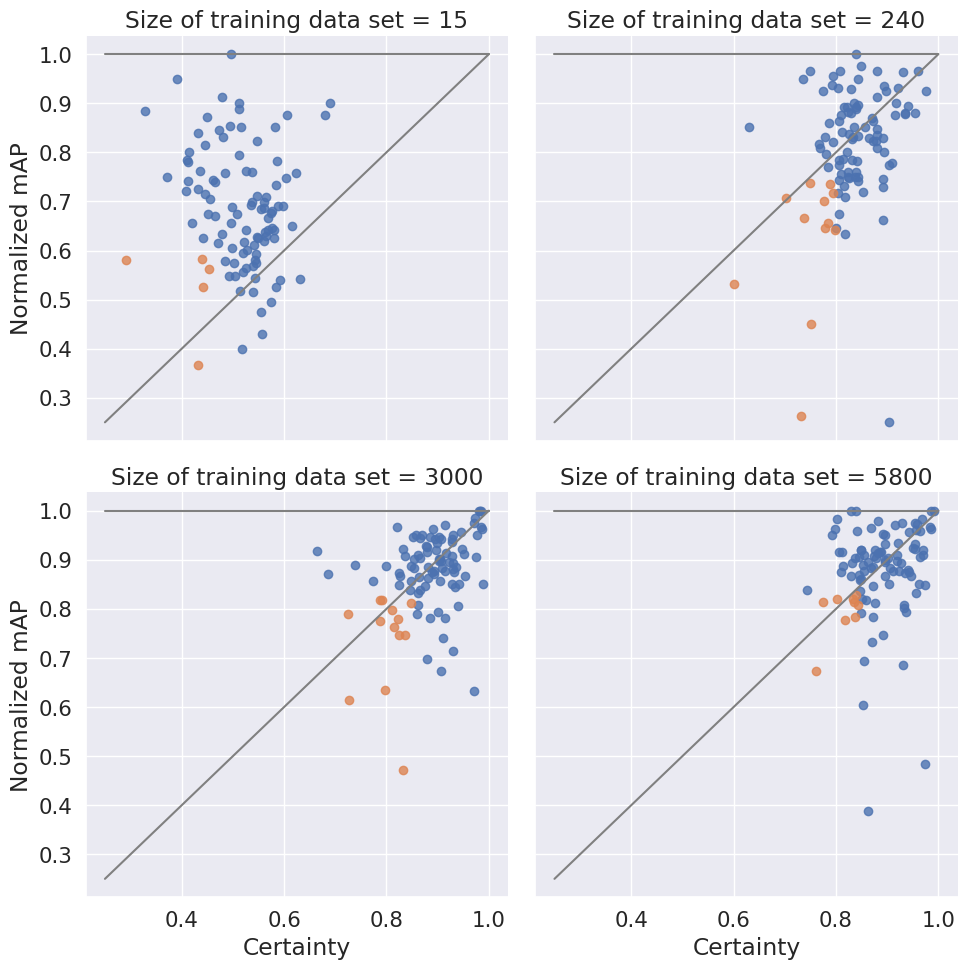

{'dropout_prob': 0.15, 'num_mc_samples': 40}


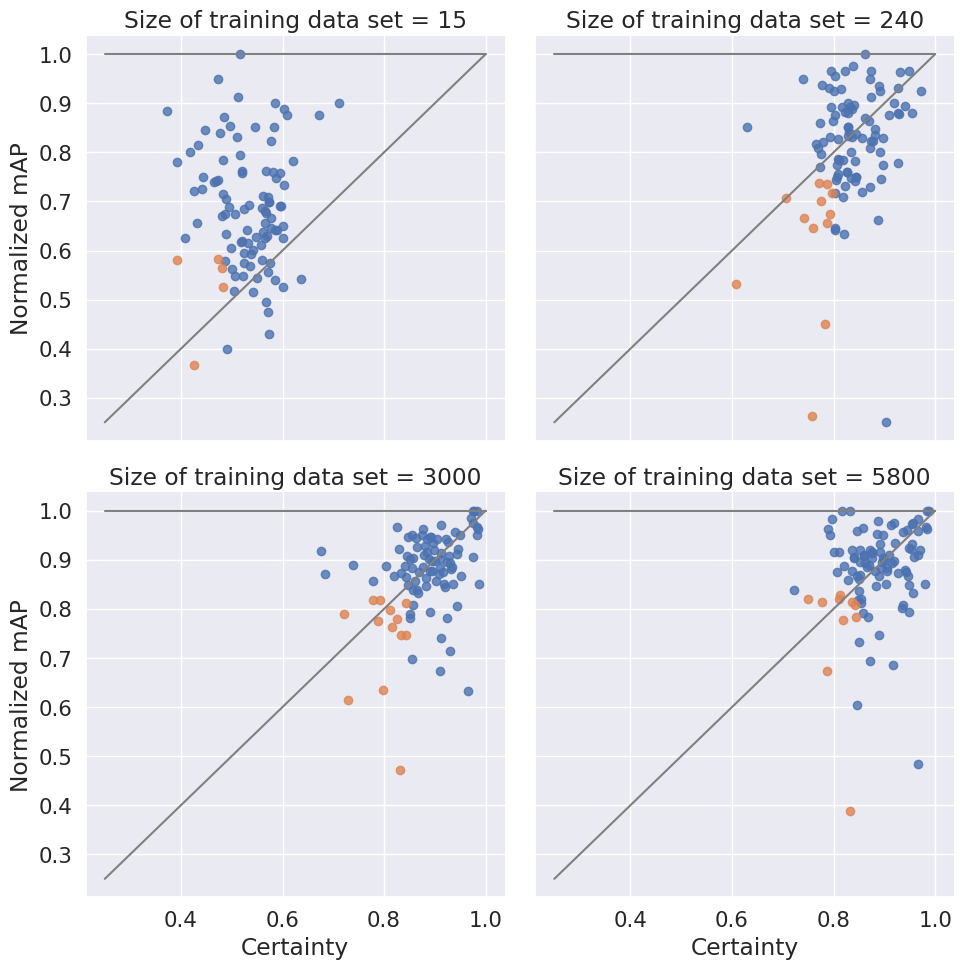

{'dropout_prob': 0.15, 'num_mc_samples': 5}


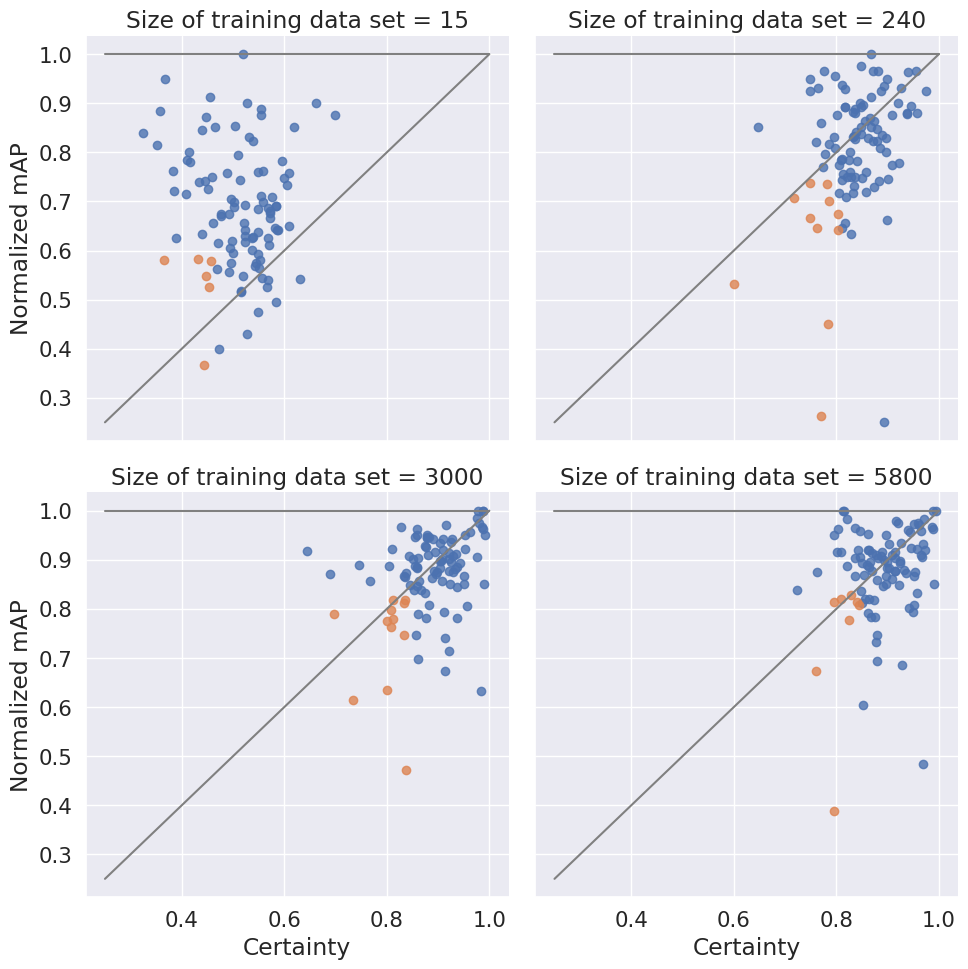

{'dropout_prob': 0.15, 'num_mc_samples': 30}


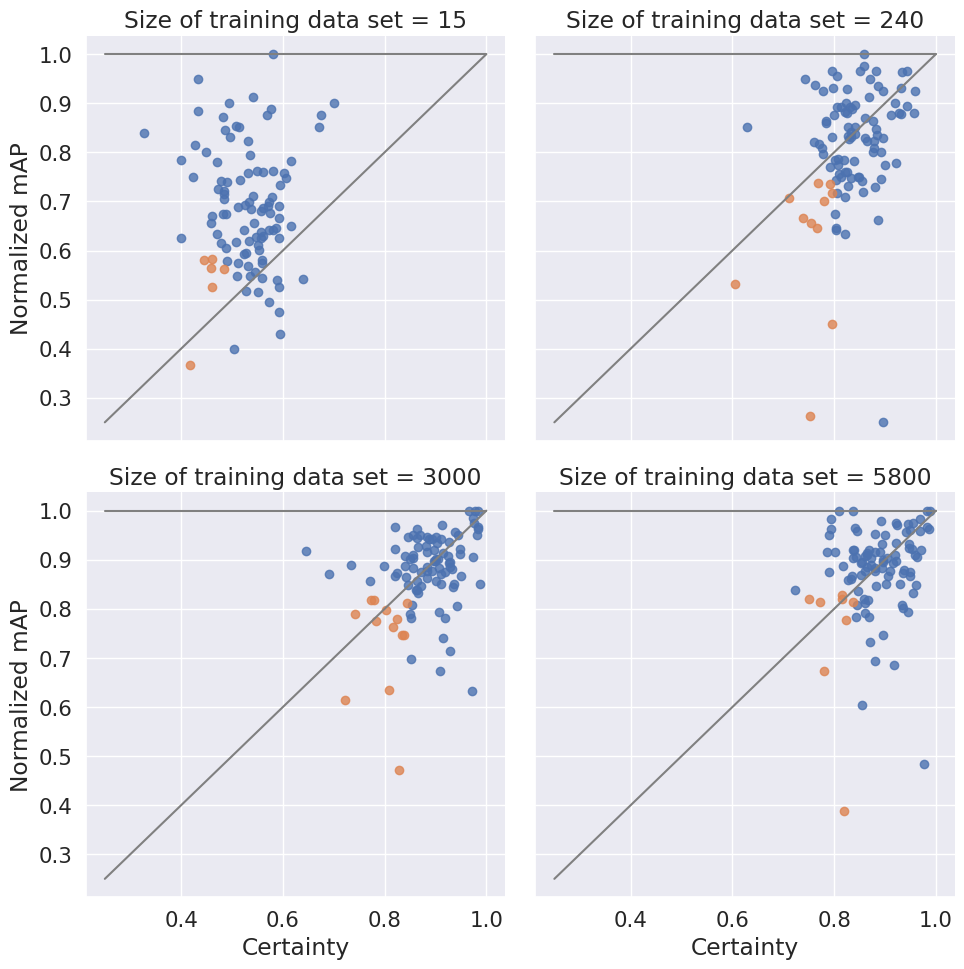

{'dropout_prob': 0.1, 'num_mc_samples': 20}


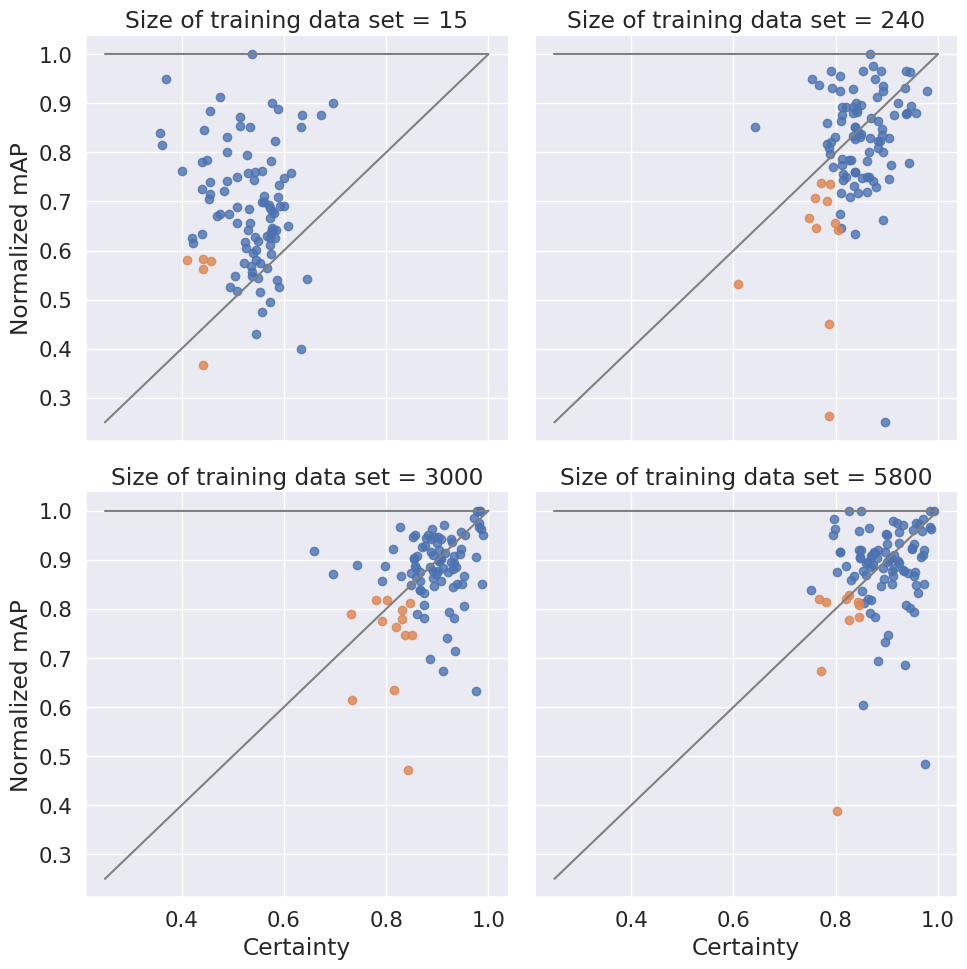

{'dropout_prob': 0.1, 'num_mc_samples': 10}


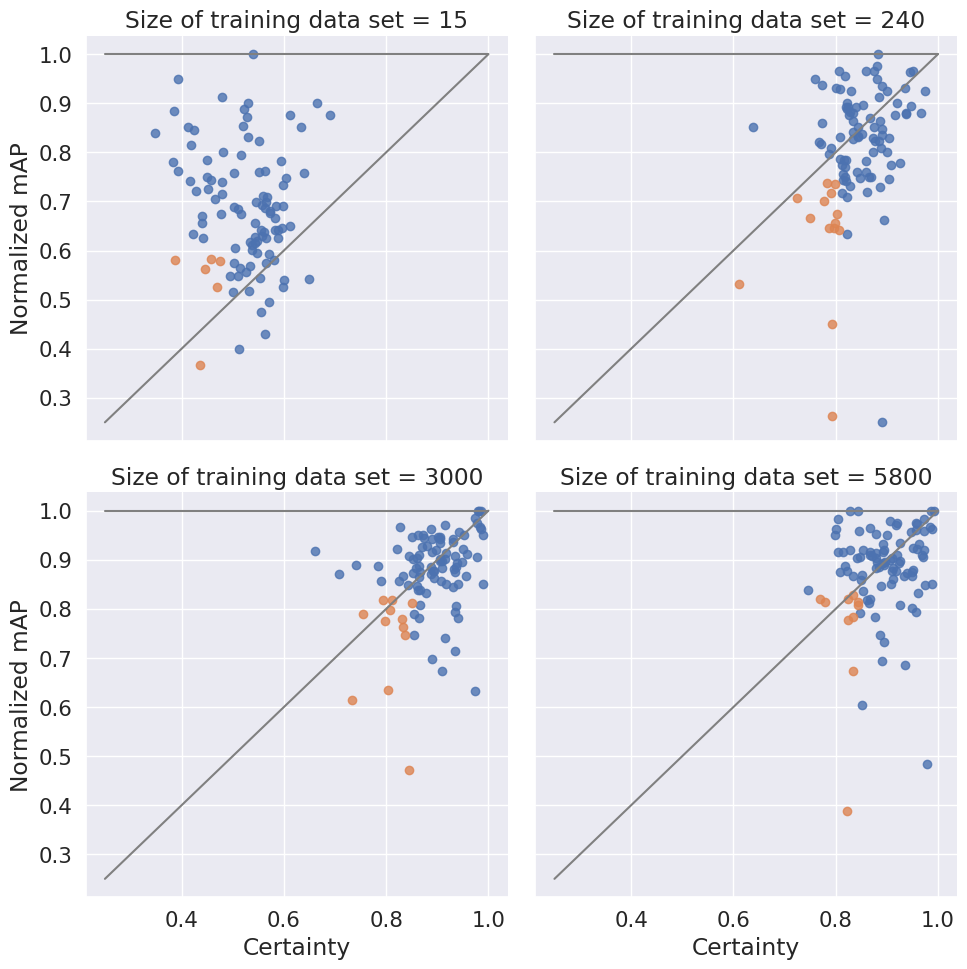

{'dropout_prob': 0.1, 'num_mc_samples': 40}


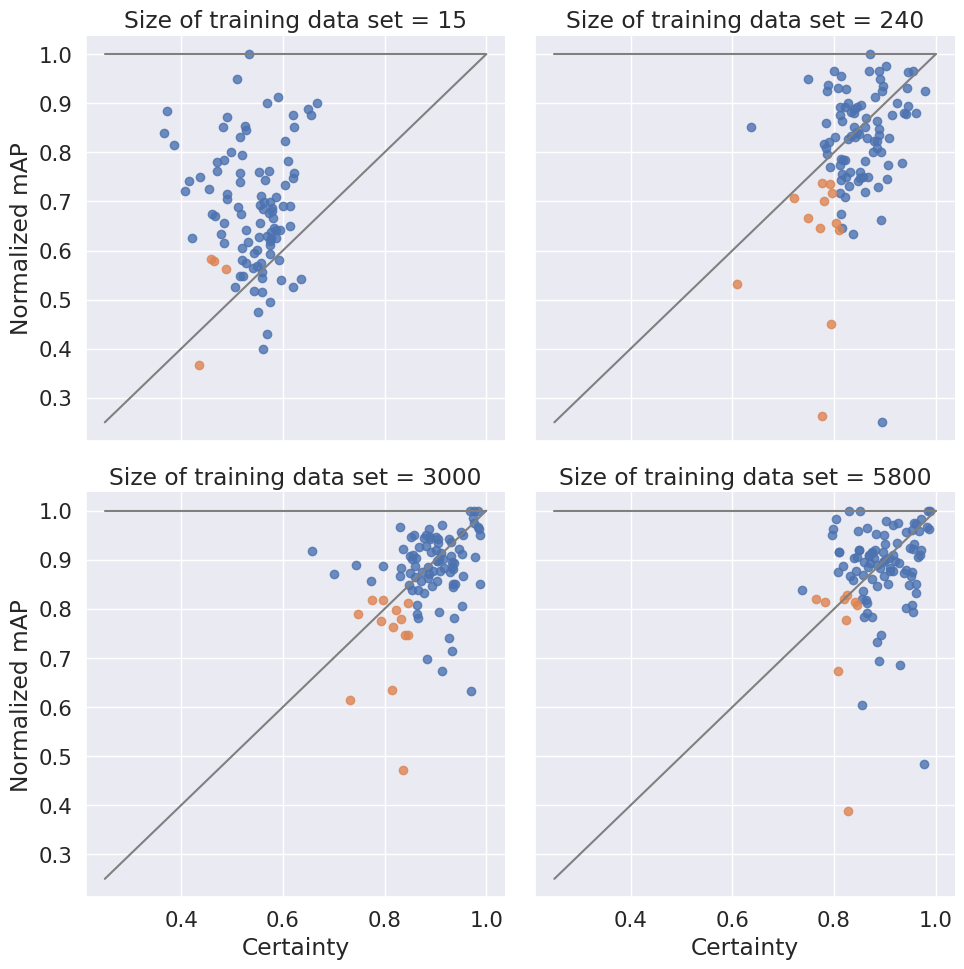

{'dropout_prob': 0.1, 'num_mc_samples': 5}


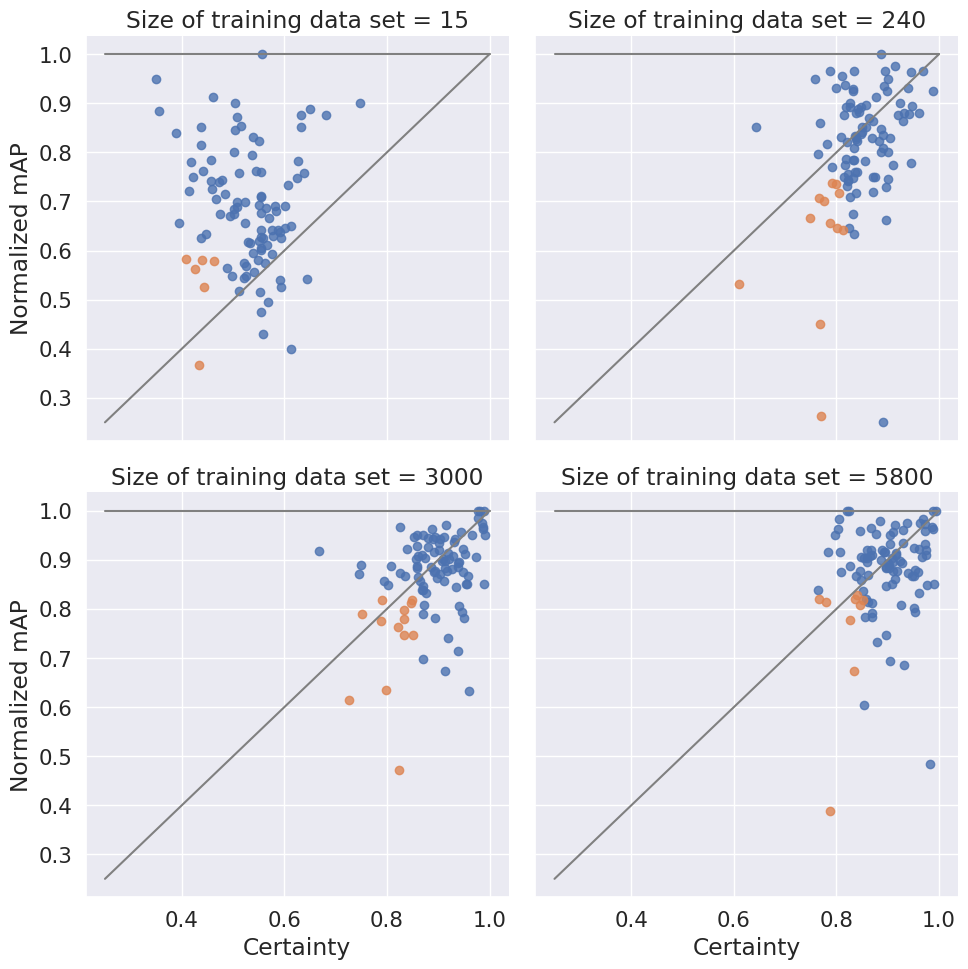

{'dropout_prob': 0.1, 'num_mc_samples': 30}


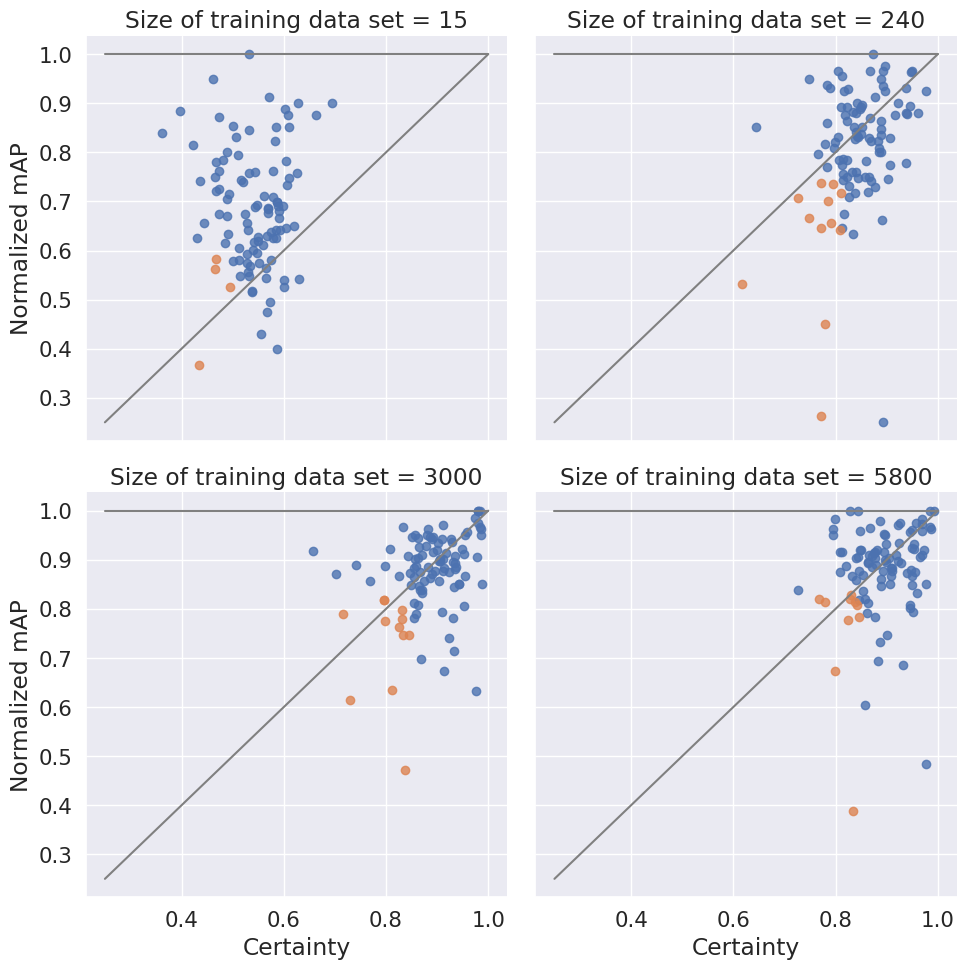

{'dropout_prob': 0.25, 'num_mc_samples': 20}


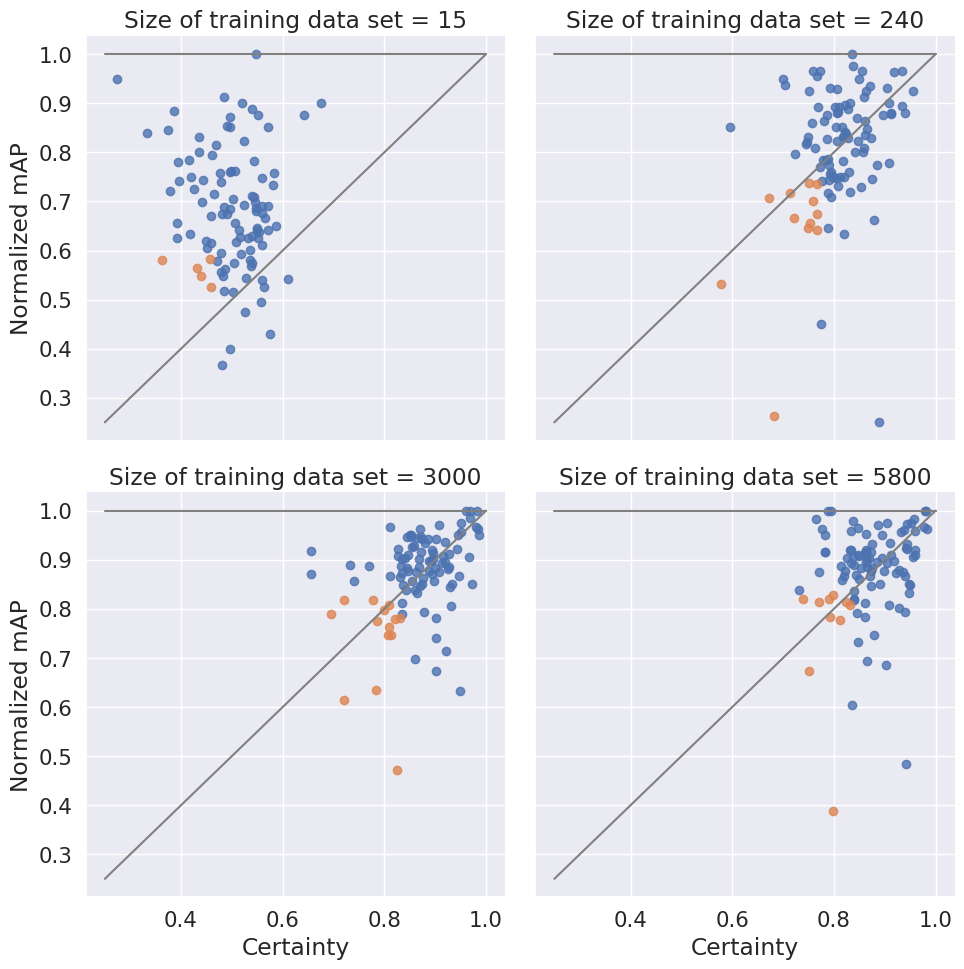

{'dropout_prob': 0.25, 'num_mc_samples': 10}


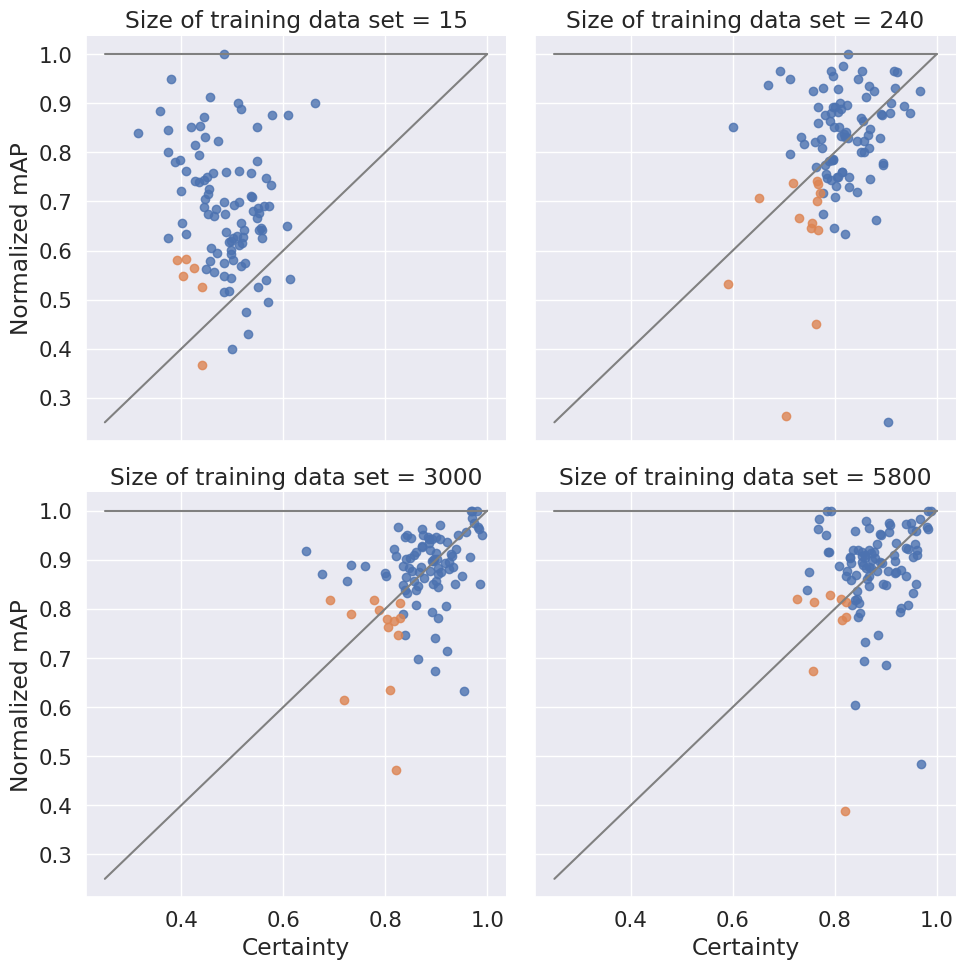

{'dropout_prob': 0.25, 'num_mc_samples': 40}


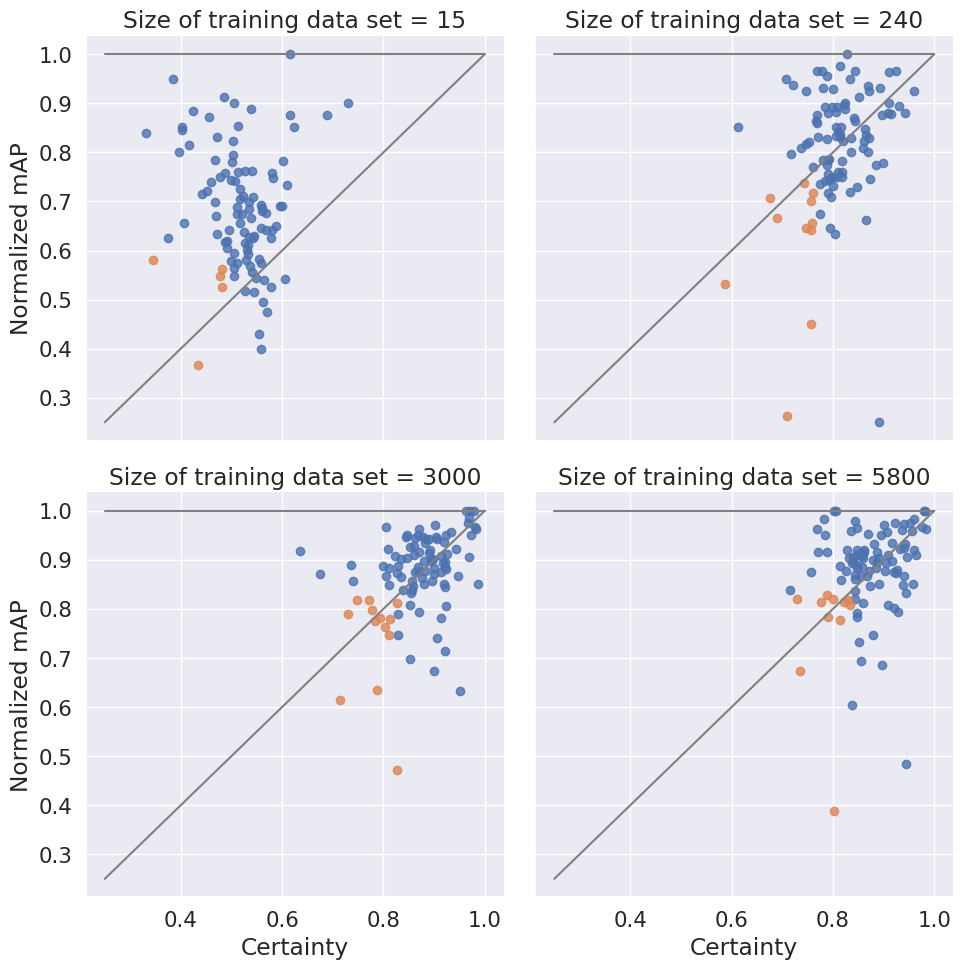

{'dropout_prob': 0.25, 'num_mc_samples': 5}


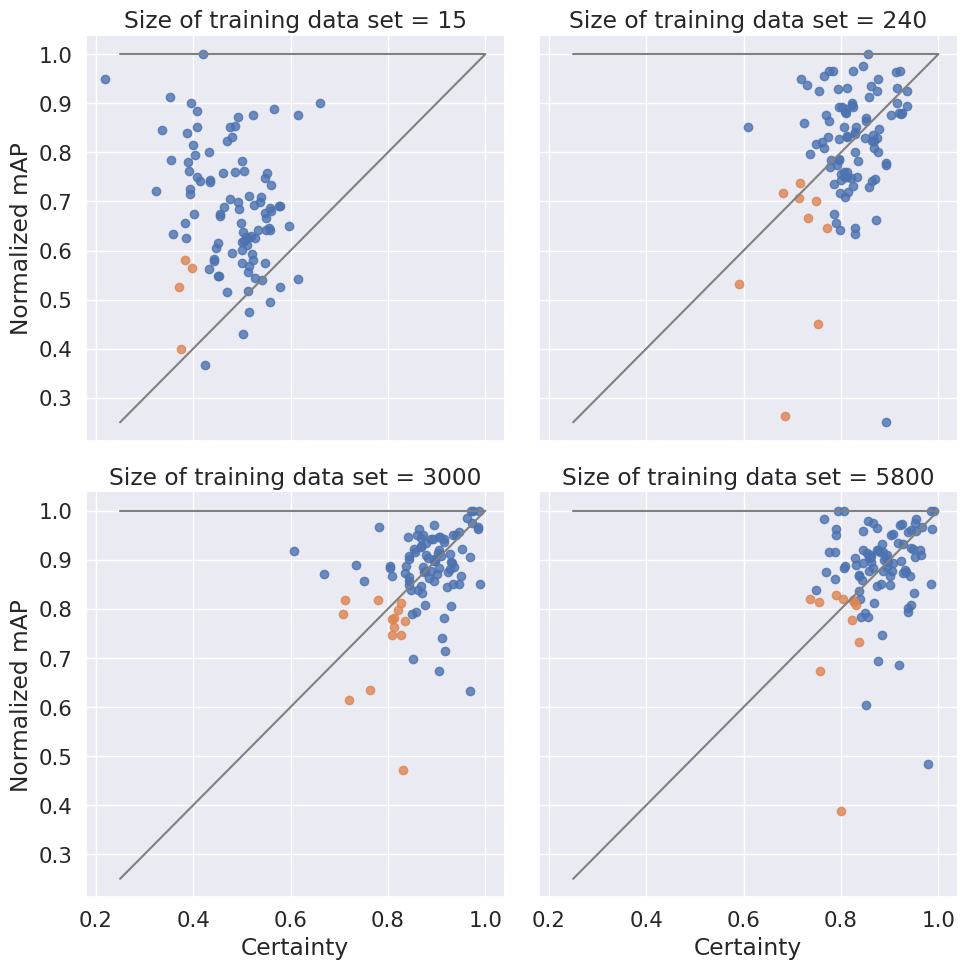

{'dropout_prob': 0.25, 'num_mc_samples': 30}


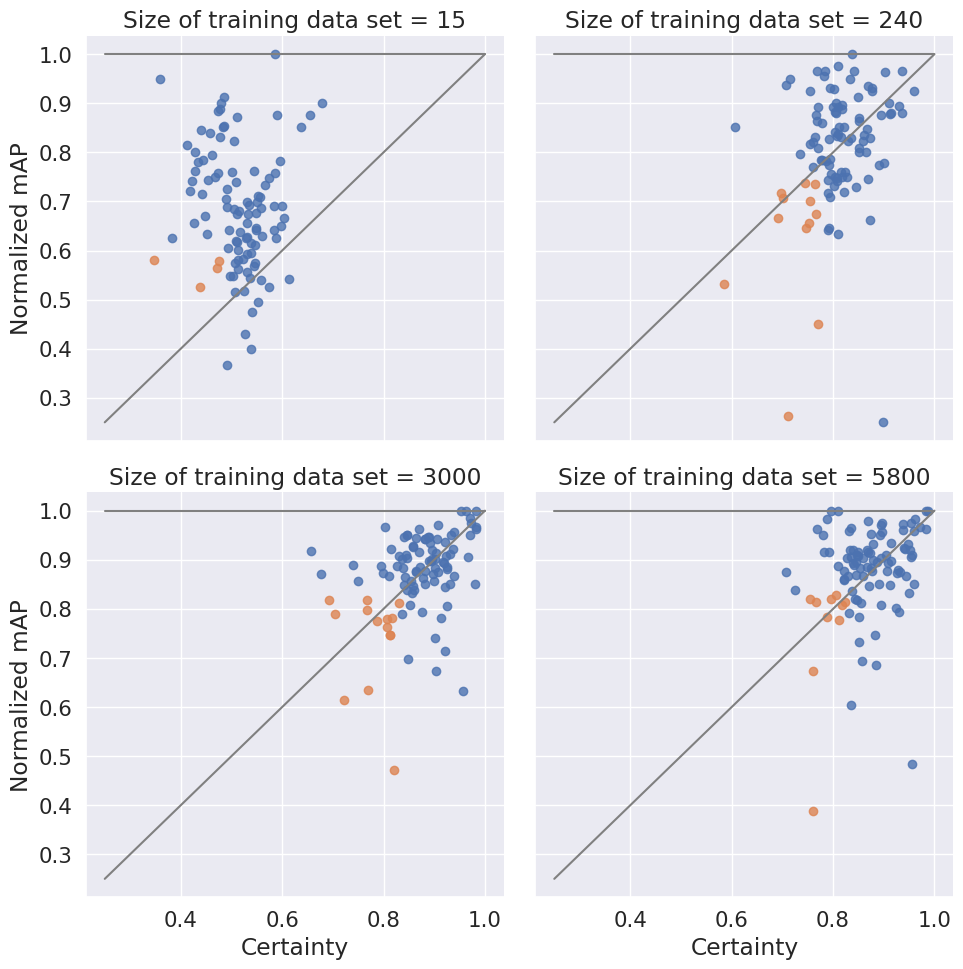

{'dropout_prob': 0.45, 'num_mc_samples': 20}


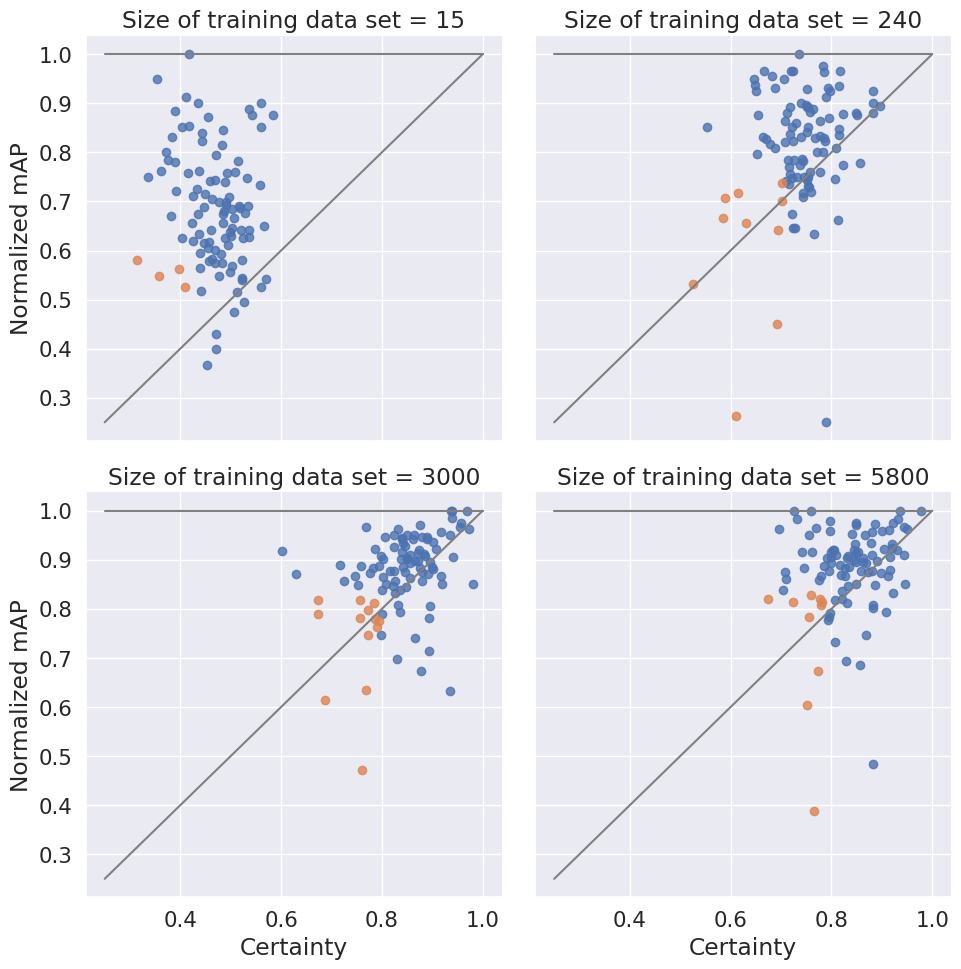

{'dropout_prob': 0.45, 'num_mc_samples': 10}


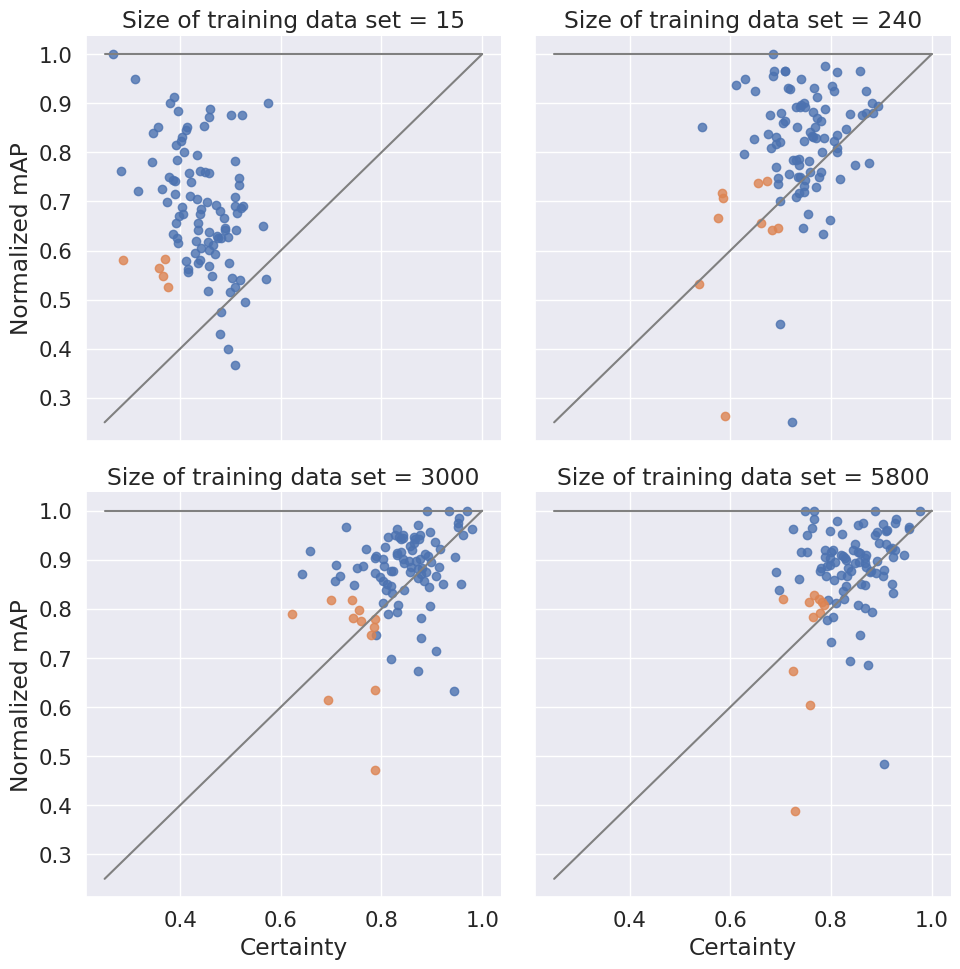

{'dropout_prob': 0.45, 'num_mc_samples': 40}


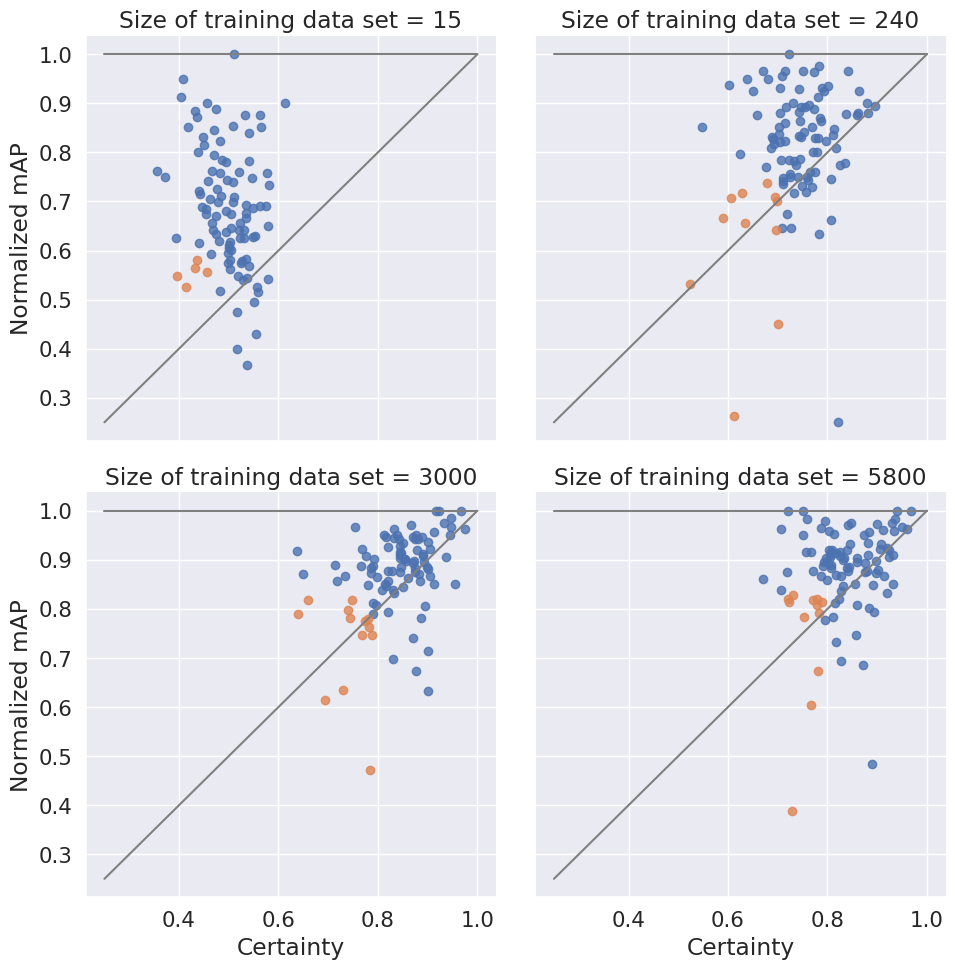

{'dropout_prob': 0.45, 'num_mc_samples': 5}


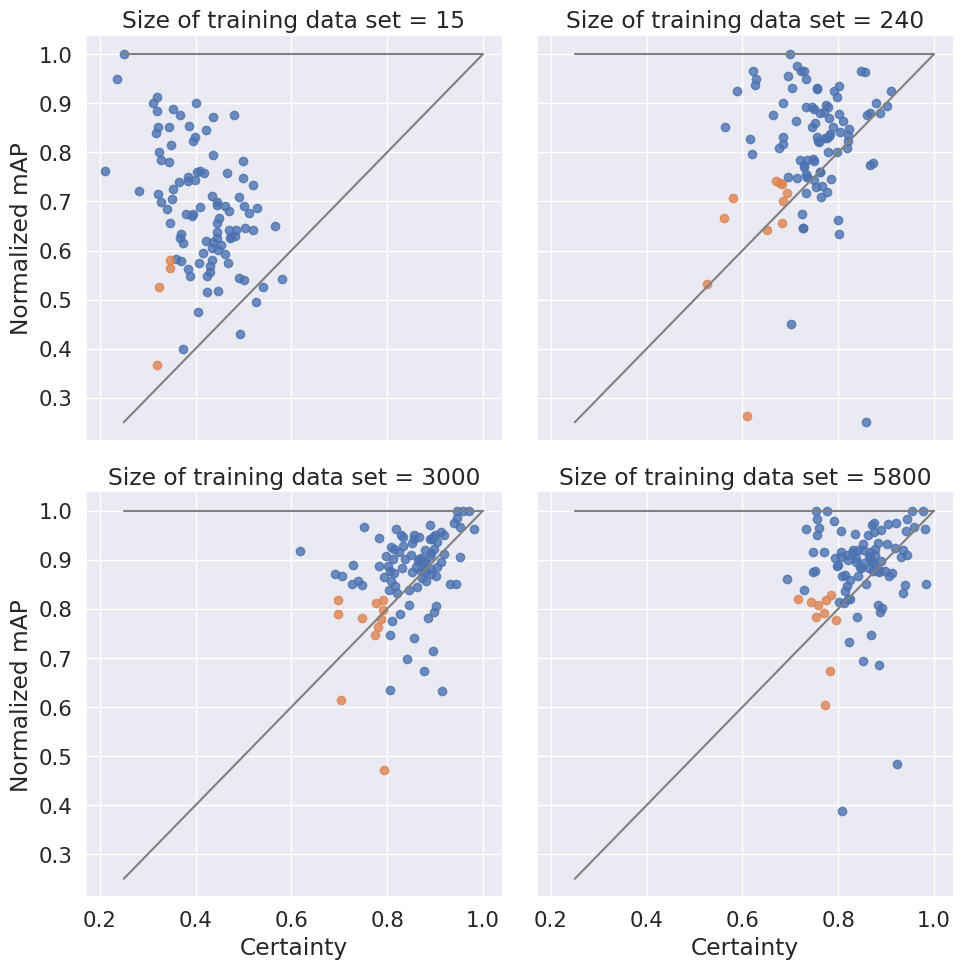

{'dropout_prob': 0.45, 'num_mc_samples': 30}


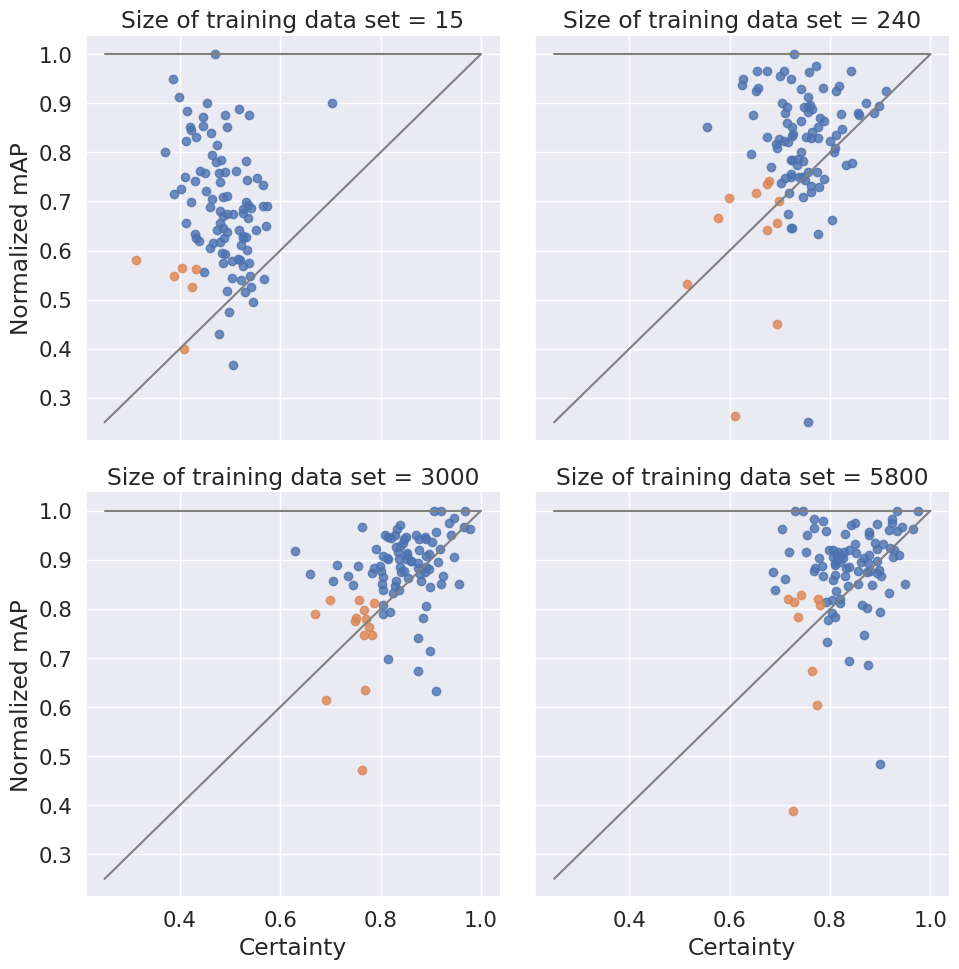

{'dropout_prob': 0.35, 'num_mc_samples': 20}


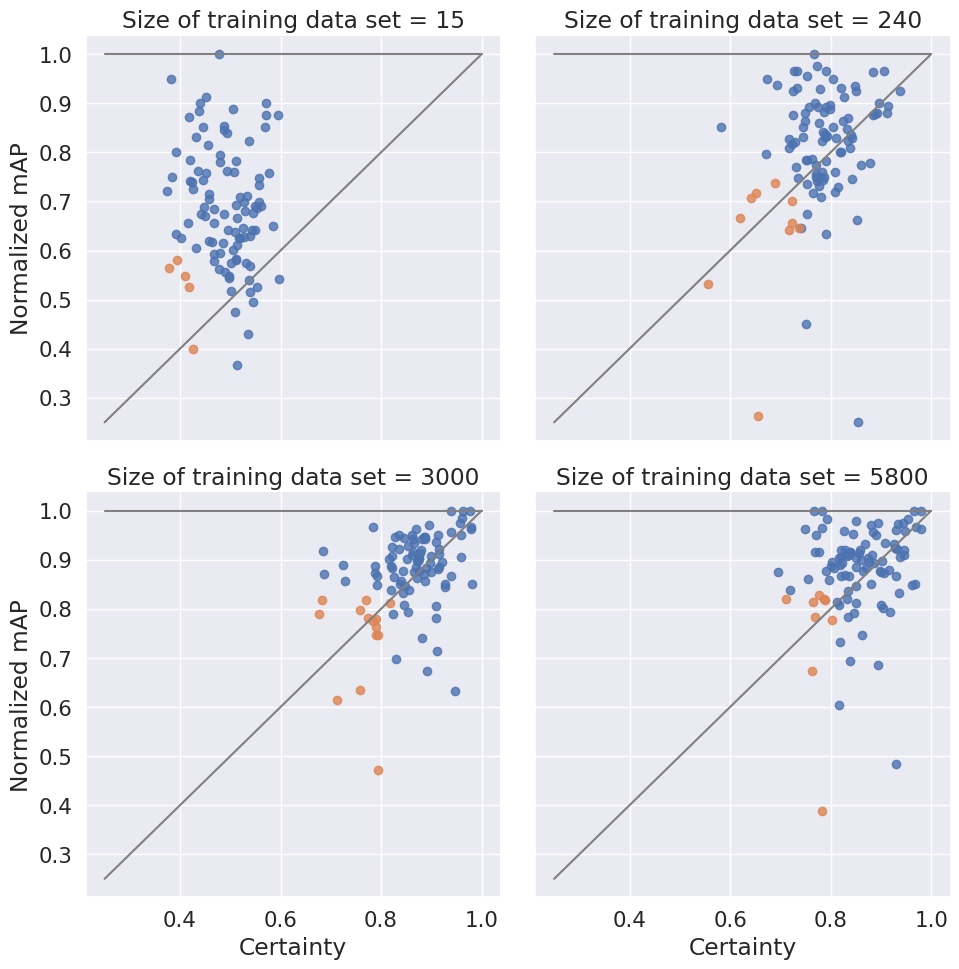

{'dropout_prob': 0.35, 'num_mc_samples': 10}


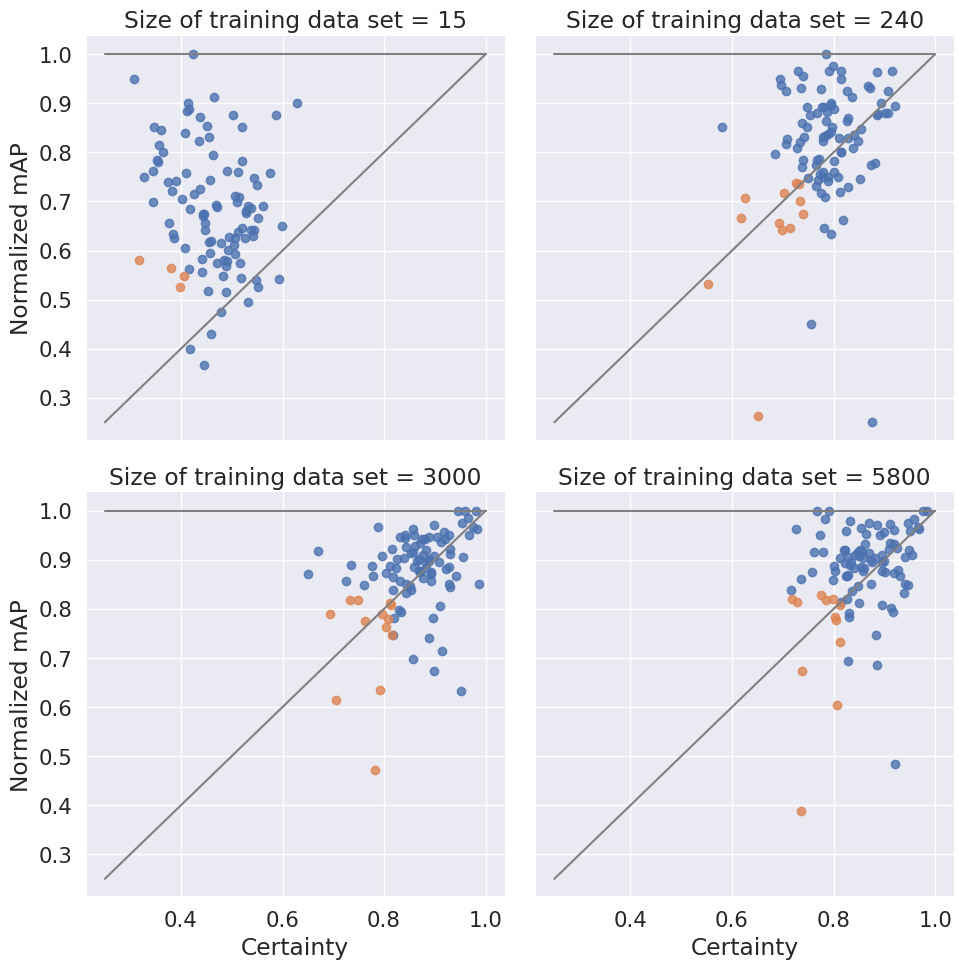

{'dropout_prob': 0.35, 'num_mc_samples': 40}


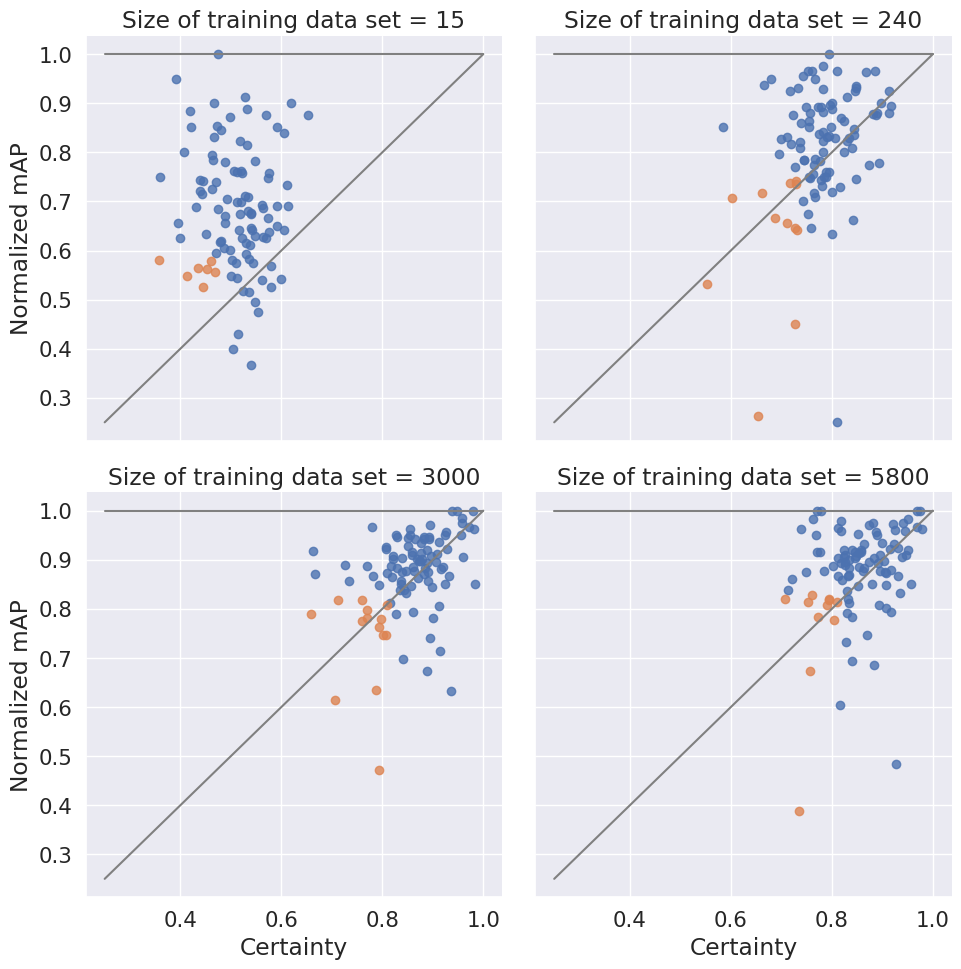

{'dropout_prob': 0.35, 'num_mc_samples': 5}


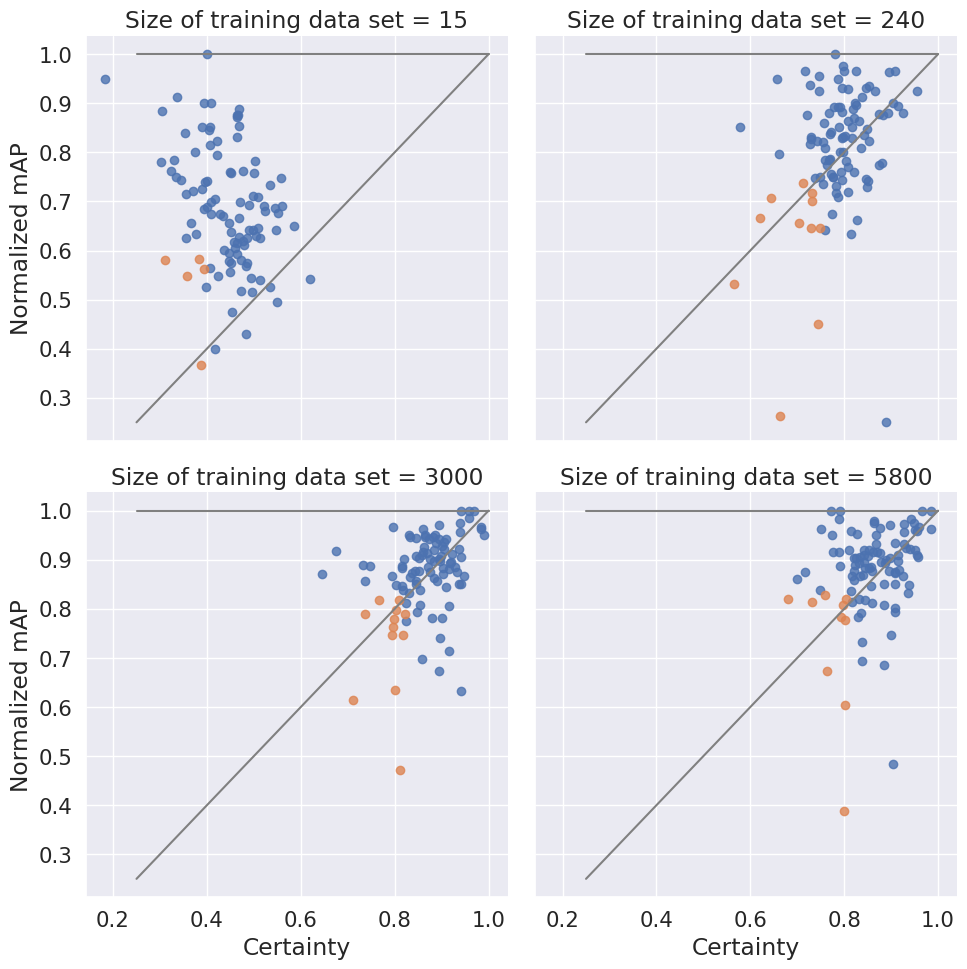

{'dropout_prob': 0.35, 'num_mc_samples': 30}


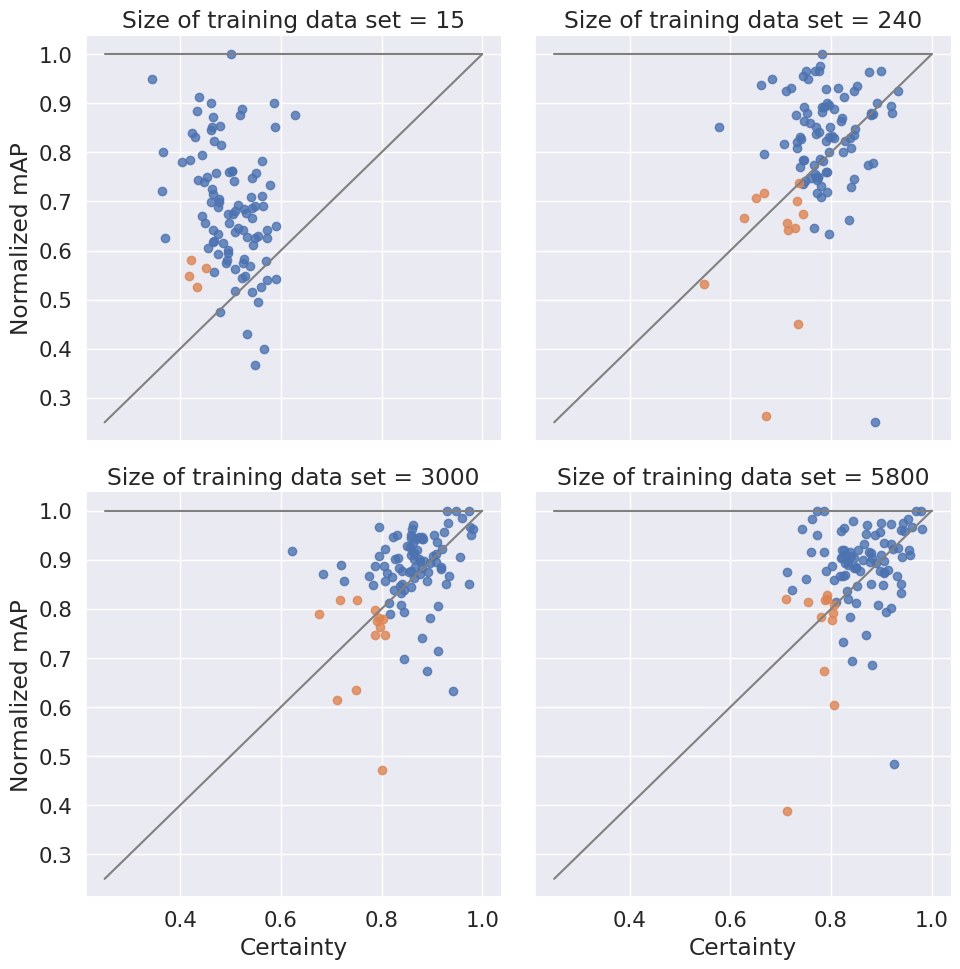

In [5]:

experiment_dir="mc_drop_gridsearch"
filename = "results_"
agg_cols = ["num_mc_samples","dropout_prob", "model_train_size"]

get_experiment(path, experiment_dir, filename,  agg_cols)

In [6]:

experiment_dir="mc_drop_aggregation"
filename = "mc_drop_agg"
agg_cols = ["cut","agg", "mask_iou", "model_train_size"]
#agg_cols = ["agg","model_train_size"]

get_experiment(path, experiment_dir, filename,  agg_cols, filter_cols={"cut":False, "mask_iou":True})

file ignored: .ipynb_checkpoints


KeyError: 'dropout_prob'

In [ ]:

experiment_dir="tta_gridsearch"
filename = "tta_gridseach"
agg_cols = ["num_mc_samples","max_noise", "model_train_size"]

get_experiment(path, experiment_dir, filename,  agg_cols)